In [40]:
import glob
import os
import pandas as pd
import chardet
import statsmodels.api as sm
import statsmodels.formula.api as smf

from statsmodels.tsa.stattools import coint, adfuller
from statsmodels.graphics.regressionplots import abline_plot
import matplotlib
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
import numpy as np
from numpy import random
from sklearn.linear_model import LinearRegression, Lasso, Ridge
import seaborn as sns
from pandas import Series
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV
from sklearn.kernel_ridge import KernelRidge


In [121]:
with open('output.csv', 'rb') as f:
    result = chardet.detect(f.read())
result['encoding']
df = pd.read_csv('output.csv', sep='\t', encoding=result['encoding'],parse_dates=[0])

In [122]:
df.head()

,Unnamed: 0,emission,mass,wheel,eng_pow,year,month,day
0,2011-01-28,155.000000,1240.0,2452.0,114.53899,2011,1,28
1,2011-06-20,314.000000,1225.0,2575.0,114.53899,2011,6,20
2,2011-02-20,0.000000,1415.0,1810.0,114.53899,2011,2,20
3,2011-09-23,140.533296,1788.0,2620.0,114.53899,2011,9,23
4,2011-02-23,140.533296,1727.0,2620.0,114.53899,2011,2,23


In [123]:
mean = df.groupby('year')['emission'].mean()

In [124]:
mean

year
2011    154.554119
2012    150.653191
2013    142.935385
2014    139.487536
2015    133.046875
2016    128.647657
Name: emission, dtype: float64

In [125]:
df = df.drop(df.columns[0], axis=1)

In [126]:
df['datetime'] = pd.to_datetime(df.year * 10000 + df.month * 100 + df.day, format='%Y%m%d')
df.head()

,emission,mass,wheel,eng_pow,year,month,day,datetime
0,155.000000,1240.0,2452.0,114.53899,2011,1,28,2011-01-28
1,314.000000,1225.0,2575.0,114.53899,2011,6,20,2011-06-20
2,0.000000,1415.0,1810.0,114.53899,2011,2,20,2011-02-20
3,140.533296,1788.0,2620.0,114.53899,2011,9,23,2011-09-23
4,140.533296,1727.0,2620.0,114.53899,2011,2,23,2011-02-23


In [127]:
df = df.drop(df.columns[[4,5,6]], axis=1)
df = df.set_index('datetime', drop=True)
df.head()

,emission,mass,wheel,eng_pow
datetime,,,,
2011-01-28,155.000000,1240.0,2452.0,114.53899
2011-06-20,314.000000,1225.0,2575.0,114.53899
2011-02-20,0.000000,1415.0,1810.0,114.53899
2011-09-23,140.533296,1788.0,2620.0,114.53899
2011-02-23,140.533296,1727.0,2620.0,114.53899


In [128]:
df.shape

(2509155, 4)

In [129]:
df = df.drop_duplicates(keep=False, inplace=False)

In [136]:
df.head()

,emission,mass,wheel,eng_pow
datetime,,,,
2011-06-20,314.000000,1225.0,2575.0,114.53899
2011-02-20,0.000000,1415.0,1810.0,114.53899
2011-09-23,140.533296,1788.0,2620.0,114.53899
2011-02-23,140.533296,1727.0,2620.0,114.53899
2011-12-19,140.533296,1787.0,2620.0,114.53899


In [131]:
emission_mean = df.emission.resample('Y').mean()
emission_sum = df.emission.resample('Y').sum()
mass_mean = df.mass.resample('Y').mean()
wheel = df.wheel.resample('Y').mean()
eng_pow = df.eng_pow.resample('Y').mean()

In [132]:
data = pd.concat([emission_mean,mass_mean,wheel,eng_pow], axis=1)
data

,emission,mass,wheel,eng_pow
datetime,,,,
2011-12-31,164.501492,1603.216633,2643.400532,106.121036
2012-12-31,166.229009,1674.735780,2753.945705,110.887921
2013-12-31,160.485193,1648.389660,2756.038703,114.669552
2014-12-31,157.009439,1689.780637,2758.328227,120.099768
2015-12-31,146.506940,1695.959426,2752.374988,129.798078
2016-12-31,142.435862,1700.902656,2777.432342,128.906703


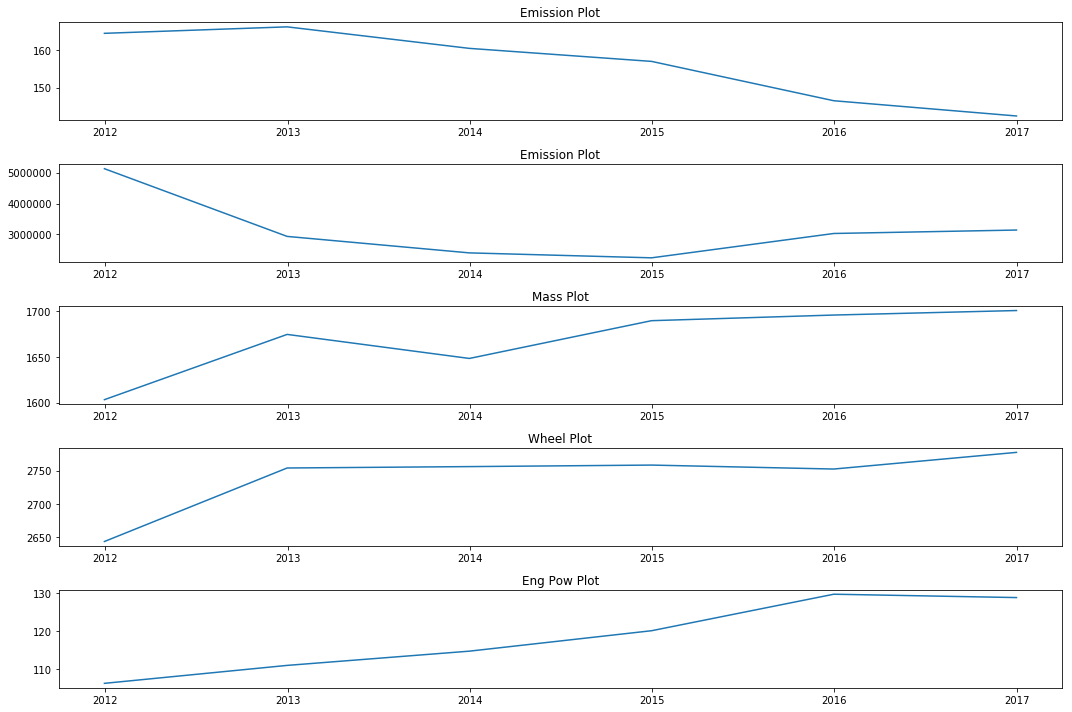

In [133]:
def tm_plot(func, series1, series2, series3,series4,series5):
    fig, ax = plt.subplots(2,figsize=(15,10))
    
    plt.subplot(511)
    func(series1)
    plt.title('{} {}'.format(series1.name, func.__name__).replace('_', ' ').title())
    
    plt.subplot(512)
    func(series2)
    plt.title('{} {}'.format(series2.name, func.__name__).replace('_', ' ').title())

    plt.subplot(513)
    func(series3)
    plt.title('{} {}'.format(series3.name, func.__name__).replace('_', ' ').title())

    plt.subplot(514)
    func(series4)
    plt.title('{} {}'.format(series4.name, func.__name__).replace('_', ' ').title())

    plt.subplot(515)
    func(series5)
    plt.title('{} {}'.format(series5.name, func.__name__).replace('_', ' ').title())

    plt.tight_layout()
    plt.show()
    
tm_plot(plt.plot, emission_mean, emission_sum, mass_mean, wheel, eng_pow)


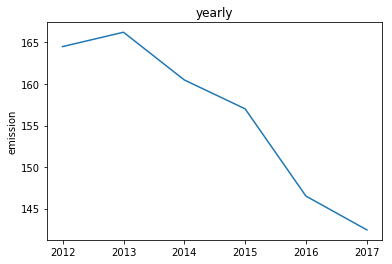

In [134]:
plt.figure()
plt.plot(df.emission.resample('Y').mean())
plt.ylabel('emission')
plt.title('yearly')
plt.show()

## Test Stationary

In [15]:
data.head()

,emission,mass,wheel,eng_pow
datetime,,,,
2011-12-31,154.554119,1534.317847,2679.786650,110.153919
2012-12-31,150.653191,1566.147634,2705.235247,114.973542
2013-12-31,142.935385,1527.156023,2695.963986,111.742614
2014-12-31,139.487536,1535.526543,2703.629357,117.122551
2015-12-31,133.046875,1533.405983,2710.565110,116.450386


In [12]:
def test_stationarity(ts):
    
    #Determing rolling statistics
    
    rol_mean = ts.rolling(window = 6, center = False).mean()
    rol_std = ts.rolling(window = 6, center = False).std()

    #Plot rolling statistics:
    plt.figure(figsize=(14,8))
    orig = plt.plot(ts, color='blue',label='Original')
    mean = plt.plot(rol_mean, color='red', label='Rolling Mean')
    std = plt.plot(rol_std, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(ts, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

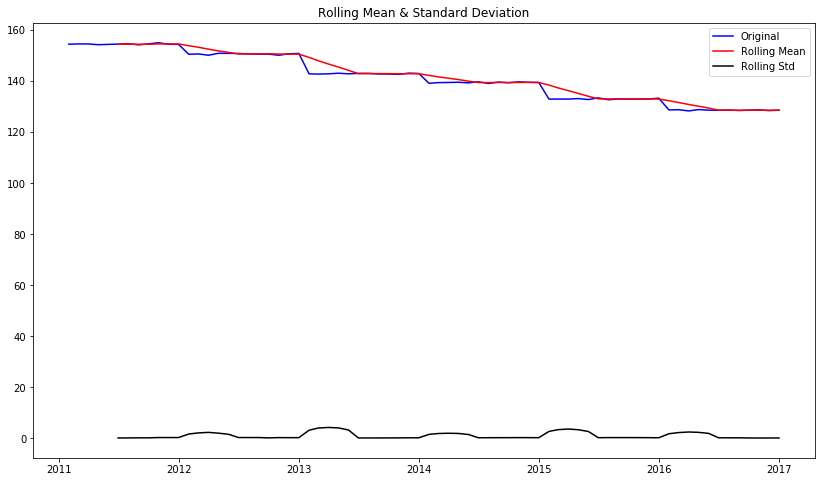

Results of Dickey-Fuller Test:
Test Statistic                 -0.591061
p-value                         0.872989
#Lags Used                     12.000000
Number of Observations Used    59.000000
Critical Value (10%)           -2.593652
Critical Value (5%)            -2.911939
Critical Value (1%)            -3.546395
dtype: float64


In [13]:
test_stationarity(emission_mean)

Weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary 

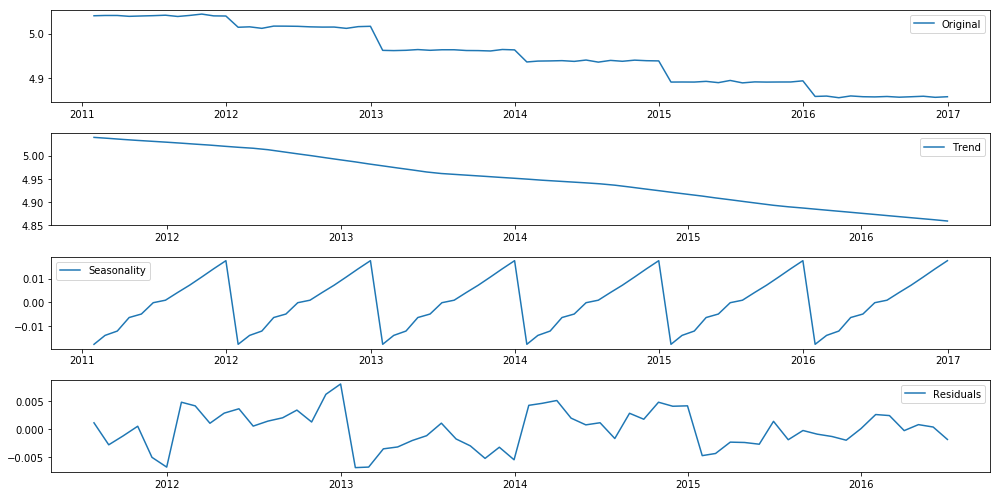

In [14]:
from statsmodels.tsa.seasonal import seasonal_decompose

dt_log = np.log(data['emission'])

decomposition = seasonal_decompose(dt_log, freq = 12)

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.figure(figsize=(14,7))
plt.subplot(411)
plt.plot(dt_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

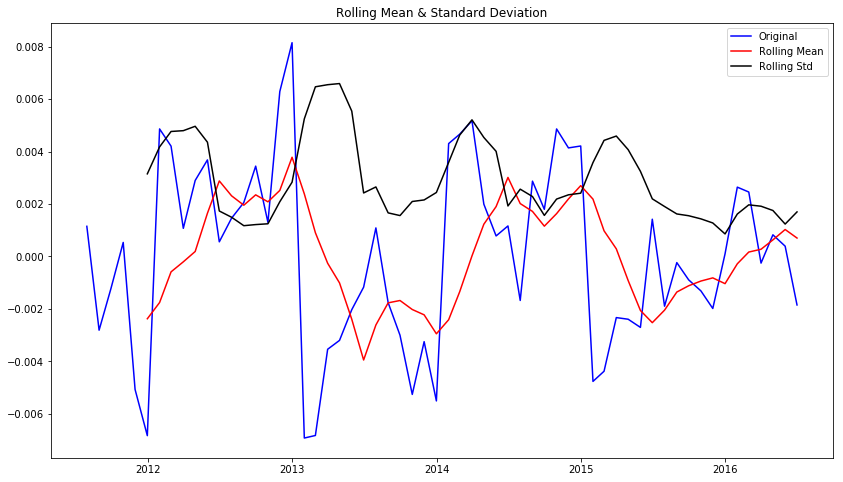

Results of Dickey-Fuller Test:
Test Statistic                -7.374959e+00
p-value                        8.771576e-11
#Lags Used                     1.100000e+01
Number of Observations Used    4.800000e+01
Critical Value (10%)          -2.600039e+00
Critical Value (5%)           -2.923954e+00
Critical Value (1%)           -3.574589e+00
dtype: float64


In [15]:
ts_decompose = residual
ts_decompose.dropna(inplace=True)
test_stationarity(ts_decompose)

Strong evidence against the null hypothesis, reject the null hypothesis. Data has no unit root, hence it is stationary

## Linear Regression

In [64]:
y_data = data['emission']
x_data = data.drop('emission', axis=1)

In [65]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size=0.25, random_state=42)

In [66]:
from sklearn.linear_model import LinearRegression
clf = LinearRegression()
clf.fit(x_train, y_train)
yhat_test = clf.predict(x_test)
yhat_train = clf.predict(x_train)

yhat_test[:5]

array([ 150.42891727,  111.60014938])

In [38]:
from sklearn.metrics import r2_score
print("Test Accuracy : ",r2_score(yhat_test,y_test))
print("Training Accuracy : ",r2_score(yhat_train,y_train))

Test Accuracy :  0.989461377009
Training Accuracy :  0.99194589418


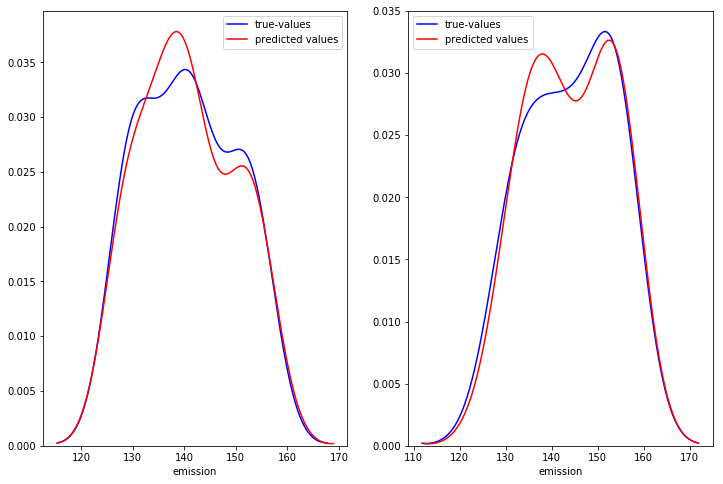

In [39]:
fig , (ax1, ax2) = plt.subplots(1,2,figsize=(12,8))
sns.distplot(y_train, color = 'b', label="true-values", hist=False, ax = ax1)
sns.distplot(yhat_train, color='r', label="predicted values", hist= False , ax = ax1)

sns.distplot(y_test, color = 'b', label="true-values", hist=False, ax= ax2)
sns.distplot(yhat_test, color='r', label="predicted values", hist= False , ax = ax2)
plt.show()

## cross validation 

In [21]:
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import cross_val_score

score_cv = cross_val_score(clf,x_train, y_train, cv = 4)
print("Mean Accuracy of training data using 4 folds :",score_cv.mean())

Mean Accuracy of training data using 4 folds : 0.990559492872


In [22]:
score_cv = cross_val_score(clf,x_test, y_test, cv = 4)
print("Mean Accuracy of test data using 4 folds :",score_cv.mean())

Mean Accuracy of test data using 4 folds : 0.950145147097


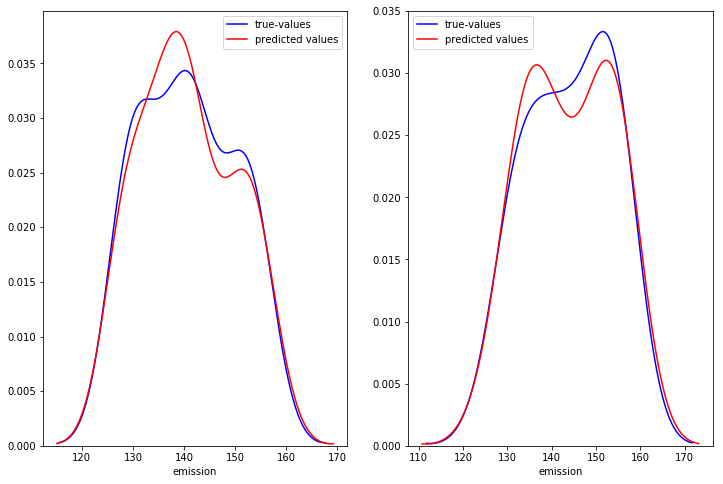

In [23]:
ytest_cv = cross_val_predict(clf,x_test,y_test,cv= 4)
ytrain_cv = cross_val_predict(clf,x_train,y_train,cv =4)

fig , (ax1, ax2) = plt.subplots(1,2,figsize=(12,8))
sns.distplot(y_train, color = 'b', label="true-values", hist=False, ax = ax1)
sns.distplot(ytrain_cv, color='r', label="predicted values", hist= False , ax = ax1)

sns.distplot(y_test, color = 'b', label="true-values", hist=False, ax= ax2)
sns.distplot(ytest_cv, color='r', label="predicted values", hist= False , ax = ax2)
plt.show()

## Autocorrelation

## ARIMA

In [84]:
emission = df.emission.resample('Y').mean()

In [85]:
emission


datetime
2011-12-31    154.554119
2012-12-31    150.653191
2013-12-31    142.935385
2014-12-31    139.487536
2015-12-31    133.046875
2016-12-31    128.647657
Freq: A-DEC, Name: emission, dtype: float64

In [72]:
from pandas.plotting import lag_plot
from pandas.plotting import autocorrelation_plot
from sklearn.metrics import mean_squared_error
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.ar_model import AR


In [86]:

def fit_AR1(series):
    vals = emission
    train, test = vals[1:len(vals) - 2], vals[len(vals) - 2:]
    

    model = AR(train)
    model_fit = model.fit()
    print(series.name)
    print('Lag: %s' % model_fit.k_ar)
    predictions = model_fit.predict(start=len(train), end=len(train)+len(test)-1, dynamic=False)
    for i in range(len(predictions)):
        error = mean_squared_error(test, predictions)
    print('Test_Active MSE: %.3f' % error)
    return test, predictions

t1, p1 = fit_AR1(emission_mean)
print()
plt.figure(figsize=(10,8))
plt.plot(data.emission, label='original')
plt.plot(t1, label='test_data')
plt.plot(p1, color='red', label='AR_predictions')
plt.title('emission')
plt.legend()
plt.show()

ValueError: maxlag should be < nobs